<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/marco-canas/machine_learning/blob/main/classes/class_march_15/class_march_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# [Medidas de desempeño para un clasificador](https://www.knowledgeisle.com/wp-content/uploads/2019/12/2-Aur%C3%A9lien-G%C3%A9ron-Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-Tensorflow_-Concepts-Tools-and-Techniques-to-Build-Intelligent-Systems-O%E2%80%99Reilly-Media-2019.pdf) 

## Medición de la exactitud mediante validación cruzada

Evaluar un clasificador suele ser significativamente más complicado que evaluar un regresor, por lo que dedicaremos gran parte de este capítulo a este tema. 

Hay muchas medidas de desempeño disponibles. 

## Medición de la precisión mediante validación cruzada

Una buena manera de evaluar un modelo es usar la validación cruzada, tal como lo hizo en el Capítulo 2.

## Implementación de validación cruzada

Ocasionalmente, necesitará más control sobre el proceso de validación cruzada que el que Scikit-Learn proporciona de manera estándar.

En estos casos, puede implementar la validación cruzada usted mismo; en realidad es bastante sencillo.

El siguiente código hace más o menos lo mismo que la función `cross_val_score()` de Scikit-Learn e imprime el mismo resultado:

In [1]:
import numpy as np 
from sklearn.datasets import fetch_openml 

In [2]:
%%time  
mnist = fetch_openml('mnist_784', version = 1) 

Wall time: 3min 42s


In [3]:
X,y = mnist['data'], mnist['target'] 

# Convertir a arreglos de numpy de valores enteros

In [4]:
X = X.values
y = y.values.astype(np.int64) 

In [5]:
y[0]

5

## Dividir el dataset en entrenamiento y testeo

In [6]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

# Definir la variable objetivo para clasificación binaria

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# Entrenar un Clasificador de Gradiente descendente estocástico

In [8]:
%%time  

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()

sgd_clf.fit(X_train, y_train_5) 

Wall time: 48.5 s


SGDClassifier()

# Validación cruzada personalizada

In [9]:
%%time 

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.9649

0.96765
0.9633
0.96575
Wall time: 58 s


La clase `StratifiedKFold` realiza un muestreo estratificado (como se explica en el Capítulo 2) para producir pliegues que contienen una proporción representativa de cada clase. 

En cada iteración, el código crea un clon del clasificador, entrena ese clon en los pliegues de entrenamiento y hace predicciones en el pliegue de prueba.

Luego cuenta el número de predicciones correctas y genera la proporción de predicciones correctas.

Usemos la función `cross_val_score()` para evaluar nuestro modelo `SGDClassifier`, usando la validación cruzada K-fold con tres pliegues.

Recuerde que la validación cruzada K-fold significa dividir el conjunto de entrenamiento en K pliegues (en este caso, tres), luego hacer predicciones y evaluarlas en cada pliegue usando un modelo entrenado en los pliegues restantes (ver Capítulo 2):

In [10]:
%%time 

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


Wall time: 1min


array([0.9677, 0.9592, 0.9543])

¡Guau! ¿Por encima del 93 % de precisión (proporción de predicciones correctas) en todos los subconjuntos de validación cruzada?

Esto se ve increíble, ¿no? Bueno, antes de que te emociones demasiado, echemos un vistazo a un clasificador muy tonto que simplemente clasifica cada imagen en la clase "no-5":

In [11]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

¿Puedes adivinar la exactitud de este modelo? Vamos a averiguar:


In [12]:
from sklearn.model_selection import cross_val_score 

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

¡Así es, tiene más del 90% de precisión!

Esto se debe simplemente a que solo alrededor del 10 % de las imágenes son 5, por lo que si siempre adivina que una imagen no es un 5, acertará aproximadamente el 90 % de las veces. Vence a Nostradamus.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

## Confusion Matrix  

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. 

The general idea is to count the number of times instances of class A are classified as class B. 

For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. 

You could make predictions on the test set, but let’s keep it untouched for now (remember
that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). 

Instead, you can use the cross_val_predict() function:

In [13]:
%%time 

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Wall time: 1min 20s


# Clasificación multiclase

* los clasificadores binarios distinguen entre dos clases,   
* los clasificadores multiclase (también llamados **clasificadores multinomiales**) pueden distinguir entre más de dos clases.

Algunos algoritmos 

* como los clasificadores SGD, 
* los clasificadores Random Forest

son capaces de manejar varias clases de forma nativa.

* los clasificadores de regresión logística o de 
* máquina de soporte vectorial) 

son clasificadores estrictamente binarios.

## Estrategias para realizar una clasificación multiclase con varios clasificadores binarios.

Una forma de crear un sistema que pueda clasificar las imágenes de dígitos en 10 clases (del 0 al 9) es entrenar 10 clasificadores binarios, uno para cada dígito (un detector 0, un detector 1, un detector 2, etc.)).

Luego, cuando desea clasificar una imagen, obtiene el puntaje de decisión de cada clasificador para esa imagen y selecciona la clase cuyo clasificador genera el puntaje más alto.

Esto se denomina estrategia uno contra el resto (OvR) (también llamada uno contra todos).

Otra estrategia es entrenar un clasificador binario para cada par de dígitos: uno para distinguir 0s y 1s, otro para distinguir 0s y 2s, otro para 1s y 2s, y así sucesivamente.

Esto se llama la estrategia uno contra uno (OvO).

Si hay $N$ clases, necesita entrenar 

$$ \frac{N \times  (N – 1)}{2} \ \ \ \ \  \text{clasificadores.} $$

Para el problema MNIST, ¡esto significa entrenar 45 clasificadores binarios!

Cuando desee clasificar una imagen, debe ejecutar la imagen a través de los 45 clasificadores y ver qué clase gana la mayor cantidad de duelos.

La principal ventaja de OvO es que cada clasificador solo necesita ser entrenado en la parte del conjunto de entrenamiento para las dos clases que debe distinguir.

Algunos algoritmos (como los clasificadores de máquinas de soporte vectorial) escalan mal con el tamaño del conjunto de entrenamiento.

Para estos algoritmos, se prefiere OvO porque es más rápido entrenar muchos clasificadores en pequeños conjuntos de entrenamiento que entrenar pocos clasificadores en grandes conjuntos de entrenamiento.

Sin embargo, para la mayoría de los algoritmos de clasificación binaria, se prefiere OvR.

Scikit-Learn detecta cuando intenta utilizar un algoritmo de clasificación binaria para una tarea de clasificación multiclase y automáticamente ejecuta OvR u OvO, según el algoritmo.

Intentemos esto con un clasificador de máquina de soporte vectorial, usando la clase `sklearn.svm.SVC`:

In [61]:
%%time 

from sklearn.datasets import fetch_openml 

mnist = fetch_openml('mnist_784', version = 1, as_frame = False)  

Wall time: 31.4 s


In [62]:
X,y = mnist['data'], mnist['target'] 

In [63]:
import numpy as np 

#X = X.values
#y = y.values.ravel().astype(np.int64) 

y = y.ravel().astype(np.int64) 

In [64]:
X_train, X_test, y_train, y_test = X[:60_000,:], X[60_000:,:], y[:60_000], y[60_000:] 

In [18]:
%%time  

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5

Wall time: 6min 5s


SVC()

In [19]:
svm_clf.predict(X[:5,:])

array([5, 0, 4, 1, 9], dtype=int64)

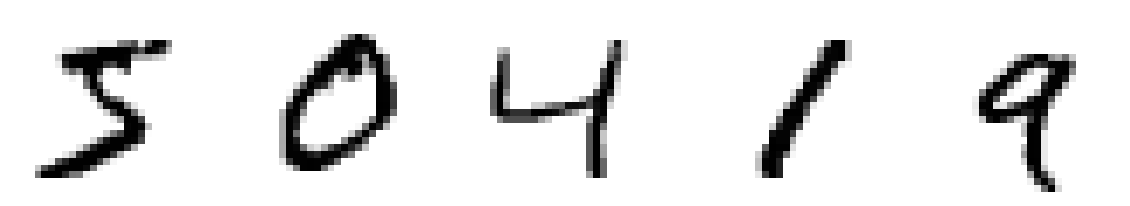

In [20]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,5, figsize = (20,6)) 

for i in range(5):
    ax[i].imshow(X[i,:].reshape(28, 28), cmap = 'binary')
    ax[i].axis('off')
    
plt.show()     


¡Eso fue fácil! Este código entrena el SVC en el conjunto de entrenamiento usando las clases de destino originales de 0 a 9 (`y_train`), en lugar de las clases de destino de 5 contra el resto (`y_train_5`).

Debajo del capó, Scikit-Learn en realidad usó la estrategia OvO: entrenó a 45 clasificadores binarios, obtuvo sus puntajes de decisión para la imagen y seleccionó la clase que ganó la mayor cantidad de duelos.

Si llama al método `decision_function()`, verá que devuelve 10 puntuaciones por instancia (en lugar de solo 1). 

Esa es una puntuación por clase:

In [65]:
puntajes_primer_digito = svm_clf.decision_function([X[0,:]])
puntajes_primer_digito


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

De hecho, la puntuación más alta es la correspondiente a la clase 5:

In [30]:
np.argmax(puntajes_primer_digito)

5

In [23]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [31]:
svm_clf.classes_[5]

5

## ADVERTENCIA

Cuando se entrena un clasificador, almacena la lista de clases objetivo en su atributo `classes_`, ordenadas por valor.

En este caso, el índice de cada clase en el arreglo `classes_` coincide convenientemente con la clase misma (por ejemplo, la clase en el índice 5 resulta ser la clase 5), pero en general no tendrá tanta suerte.

Si desea forzar a Scikit-Learn a usar uno contra uno o uno contra el resto, puede usar las clases `OneVsOneClassifier` o `OneVsRestClassifier`.

Simplemente cree una instancia y pase un clasificador a su constructor (ni siquiera tiene que ser un clasificador binario).

Por ejemplo, este código crea un clasificador multiclase usando la estrategia OvR, basado en un SVC:

In [25]:
%%time 

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict(X[:5,:])

Wall time: 36min 43s


array([5, 0, 4, 1, 9], dtype=int64)

In [27]:
len(ovr_clf.estimators_)

10

In [33]:
ovr_clf.decision_function([X[0]]) 

array([[-2.20788779, -2.52734154, -1.42209483, -0.89545795, -3.66438164,
         1.09884347, -3.13930844, -2.05006487, -2.51601851, -3.39312853]])

In [34]:
%%time 

from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SVC())
ovo_clf.fit(X_train, y_train)
ovo_clf.predict(X[:5,:])

Wall time: 4min 5s


array([5, 0, 4, 1, 9], dtype=int64)

In [35]:
ovo_clf.decision_function([X[0]]) 

array([[ 2.72420789,  2.72909219,  7.25265966,  8.30764043, -0.31037527,
         9.31302684,  0.70957317,  2.76678409,  6.22757724,  4.84005057]])

Entrenar un `SGDClassifier` (o un `RandomForestClassifier`) es igual de fácil:

In [28]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state = 42) 

In [66]:
%%time

sgd_clf.fit(X_train, y_train)

Wall time: 2min 52s


SGDClassifier(random_state=42)

In [37]:
sgd_clf.predict(X[:5,:])

array([3, 0, 4, 1, 9], dtype=int64)

In [26]:
from sklearn.ensemble import RandomForestClassifier 

rf_clf = RandomForestClassifier() 

In [39]:
%%time 

rf_clf.fit(X_train, y_train)

Wall time: 44.1 s


RandomForestClassifier()

In [40]:
rf_clf.predict(X[:5,:])

array([5, 0, 4, 1, 9], dtype=int64)

In [67]:
rf_clf.decision_function([X[0]])

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

Esta vez, Scikit-Learn no tuvo que ejecutar OvR ni OvO porque los clasificadores SGD pueden clasificar directamente las instancias en varias clases.

El método `decision_function()` ahora devuelve un valor por clase.

Veamos la puntuación que el clasificador SGD asignó a cada clase:

In [70]:
sgd_clf.decision_function([X[2]]) # predicción para la imagen correspondiente a un cero 

array([[-34143.40703505, -21942.13780869,  -4018.29275037,
         -2239.19313075,     43.09419826, -15058.88052383,
        -33653.31059893,  -8277.80610963,  -7460.52016321,
        -14180.15338984]])

Puede ver que el clasificador tiene bastante confianza en su predicción: casi todos los puntajes son en gran parte negativos, mientras que la clase 0 tiene un puntaje de 14390.

Ahora, por supuesto, desea evaluar este clasificador.

Como de costumbre, puede utilizar la validación cruzada.

Utilice la función `cross_val_score()` para evaluar la precisión del SGDClassifier:

In [43]:
%%time 

from sklearn.model_selection import cross_val_score  

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")


array([0.87365, 0.85835, 0.8689 ])

Obtiene más del 84% en todos los pliegues de prueba.

Simplemente escalando las entradas (como se discutió en el Capítulo 2) aumenta la precisión por encima del 89%:

In [44]:
%%time 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


Wall time: 10min 26s


array([0.8983, 0.891 , 0.9018])

## Análisis de errores

Si se tratara de un proyecto real, ahora seguiría los pasos de la lista de verificación del proyecto de Machine Learning (consulte el Apéndice B del texto de Géron).

Exploraría las opciones de  

* preparación de datos, 
* probaría varios modelos (seleccionando los mejores y ajustando sus hiperparámetros usando `GridSearchCV`) y   
* automatizando tanto como sea posible.

Aquí, asumiremos que ha encontrado un modelo prometedor y desea encontrar formas de mejorarlo.

Una forma de hacerlo es analizar los tipos de errores que comete.

Primero, mira la matriz de confusión.

Necesitas hacer predicciones usando la función `cross_val_predict()`, luego llama a la función `confusion_matrix()`, tal como lo hiciste antes:

In [71]:
%%time 

from sklearn.model_selection import cross_val_predict 
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

Wall time: 26min 9s


In [47]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

Eso es un montón de números. 

A menudo es más conveniente mirar una representación de imagen de la matriz de confusión, usando la función `matshow()` de `Matplotlib`:

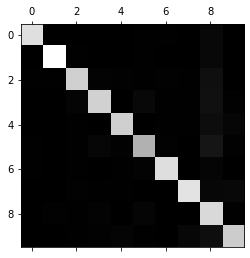

In [48]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()


Esta matriz de confusión se ve bastante bien, ya que la mayoría de las imágenes están en la diagonal principal, lo que significa que se clasificaron correctamente.

Los 5 se ven un poco más oscuros que los otros dígitos, lo que podría significar que hay menos imágenes de 5 en el conjunto de datos o que el clasificador no funciona tan bien en 5 como en otros dígitos.

De hecho, puedes verificar que ambos son el caso.

Centremos la trama en los errores.

Primero, debe dividir cada valor en la matriz de confusión por la cantidad de imágenes en la clase correspondiente para que pueda comparar las tasas de error en lugar de números absolutos de errores. (lo que haría que las clases abundantes se vieran injustamente mal):

In [49]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums


Llene la diagonal con ceros para mantener solo los errores y grafique el resultado:


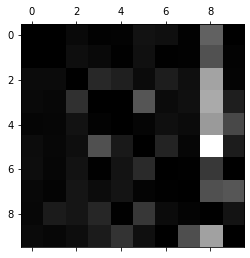

In [50]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show() 


Puede ver claramente los tipos de errores que comete el clasificador.

Recuerde que las filas representan clases reales, mientras que las columnas representan clases pronosticadas.

La columna para la clase 8 es bastante brillante, lo que indica que muchas imágenes se clasifican erróneamente como 8s.

Sin embargo, la fila para la clase 8 no es tan mala, lo que indica que los 8 reales en general se clasifican correctamente como 8.

Como puede ver, la matriz de confusión no es necesariamente simétrica. 

También puede ver que los 3 y los 5 a menudo se confunden (en ambas direcciones).

El análisis de la matriz de confusión a menudo le brinda información sobre las formas de mejorar su clasificador. 

Mirando este gráfico, parece que sus esfuerzos deben dedicarse a reducir los 8 falsos. 

Por ejemplo, podría intentar recopilar más datos de entrenamiento para los dígitos que parecen 8 (pero no lo son) para que el clasificador pueda aprender a distinguirlos de los 8 reales.

O podría diseñar nuevas características que ayudarían al clasificador, por ejemplo, escribir un algoritmo para contar la cantidad de bucles cerrados (por ejemplo, 8 tiene dos, 6 tiene uno, 5 no tiene ninguno). 

O puede preprocesar las imágenes (por ejemplo, usando Scikit-Image, Pillow u OpenCV) para hacer que algunos patrones, como los bucles cerrados, se destaquen más.

Analizar errores individuales también puede ser una buena manera de obtener información sobre lo que está haciendo su clasificador y por qué está fallando, pero es más difícil y requiere más tiempo.

Por ejemplo, grafiquemos ejemplos de 3 y 5 (la función `plot_digits()` solo usa la función `imshow()` de `Matplotlib`; consulte el cuaderno Jupyter de este capítulo para obtener más detalles):

In [52]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [56]:
import matplotlib as mpl 
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

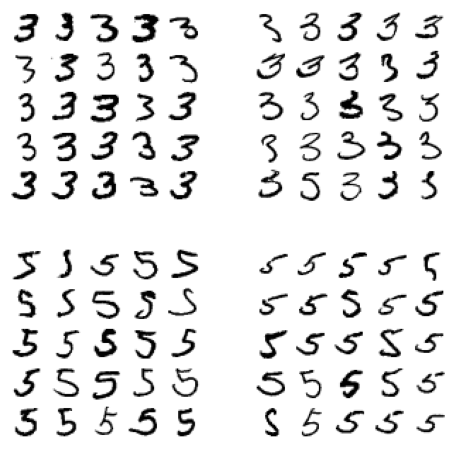

In [57]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


Los dos bloques de $5 \times 5$ de la izquierda muestran dígitos clasificados como 3 y los dos bloques de $5 \times 5$ de la derecha muestran imágenes clasificadas como 5.

Algunos de los dígitos en los que el clasificador se equivoca (es decir, en los bloques inferior izquierdo y superior derecho) están tan mal escritos que incluso un ser humano tendría problemas para clasificarlos (p. ej., el 5 en la primera fila y la segunda columna realmente parece como un mal escrito 3).

Sin embargo, la mayoría de las imágenes mal clasificadas nos parecen errores obvios, y es difícil entender por qué el clasificador cometió los errores que cometió.

La razón es que usamos un `SGDClassifier` simple, que es un modelo lineal.

Todo lo que hace es asignar un peso por clase a cada píxel, y cuando ve una nueva imagen simplemente suma las intensidades de píxel ponderadas para obtener una puntuación para cada clase. 

Entonces, dado que 3s y 5s difieren solo en unos pocos píxeles, este modelo los confundirá fácilmente.

La principal diferencia entre 3s y 5s es la posición de la pequeña línea que une la línea superior con el arco inferior. .

Si dibuja un 3 con la unión ligeramente desplazada hacia la izquierda, el clasificador podría clasificarlo como un 5 y viceversa.

En otras palabras, este clasificador es bastante sensible al desplazamiento y rotación de imágenes.

Entonces, una forma de reducir la confusión de 3/5 sería preprocesar las imágenes para asegurarse de que estén bien centradas y no demasiado giradas.

Esto probablemente también ayudará a reducir otros errores.

## Clasificación multietiqueta

Hasta ahora, cada instancia siempre se ha asignado a una sola clase.

En algunos casos, es posible que desee que su clasificador genere múltiples clases para cada instancia.

Considere un clasificador de reconocimiento facial: ¿qué debería hacer si reconoce a varias personas en la misma imagen?

Debe adjuntar una etiqueta por persona que reconozca.

Digamos que el clasificador ha sido entrenado para reconocer tres caras, Alice, Bob y Charlie.

Luego, cuando al clasificador se le muestre una imagen de Alice y Charlie, debería generar [1, 0, 1] (que significa "Alice sí, Bob no, Charlie sí").

Un sistema de clasificación de este tipo que genera múltiples etiquetas binarias se denomina **sistema de clasificación de múltiples etiquetas**.

Todavía no entraremos en el reconocimiento facial, pero veamos un ejemplo más simple, solo con fines ilustrativos:

In [58]:
%%time 

from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel) 

Wall time: 329 ms


KNeighborsClassifier()

Este código crea una matriz y_multilabel que contiene dos etiquetas objetivo para cada imagen de dígito: la primera indica si el dígito es grande o no (7, 8 o 9) y la segunda indica si es impar o no.

Las siguientes líneas crean una instancia de `KNeighborsClassifier` (que admite clasificación multietiqueta, aunque no todos los clasificadores lo hacen), y la entrenamos usando la matriz de objetivos múltiples.

Ahora puede hacer una predicción y notar que genera dos etiquetas:

In [72]:
knn_clf.predict([X[0,:]]) 

array([[False,  True]])

¡Y lo hace bien! De hecho, el dígito 5 no es grande (Falso) e impar (Verdadero).

Hay muchas formas de evaluar un clasificador de etiquetas múltiples, y seleccionar la métrica correcta realmente depende de su proyecto.

Un enfoque es medir la puntuación $F_{1}$ para cada etiqueta individual (o cualquier otra métrica de clasificador binario discutida anteriormente), luego simplemente calcular la puntuación promedio.

Este código calcula la puntuación media $F_{1}$ en todas las etiquetas:

In [ ]:
%%time 

from sklearn.metrics import f1_score 
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

Sin embargo, esto supone que todas las etiquetas son igualmente importantes, lo que puede no ser el caso.

En particular, si tiene muchas más imágenes de Alicia que de Bob o Charlie, es posible que desee dar más peso a la puntuación del clasificador en las imágenes de Alicia.

Una opción simple es dar a cada etiqueta un peso igual a su soporte (es decir, el número de instancias con esa etiqueta de destino).

Para hacer esto, simplemente establezca promedio="ponderado" en el código anterior.

## Clasificación multisalida

El último tipo de tarea de clasificación que vamos a discutir aquí se llama clasificación multisalida-multiclase (o simplemente clasificación multisalida).

Es simplemente una generalización de la clasificación multietiqueta donde cada etiqueta puede ser multiclase (es decir, puede tener más de dos valores posibles).

Para ilustrar esto, construyamos un sistema que elimine el ruido de las imágenes.

Tomará como entrada una imagen de dígito ruidosa y (con suerte) generará una imagen de dígito limpia, representada como una matriz de intensidades de píxeles, al igual que las imágenes MNIST.

Tenga en cuenta que la salida del clasificador es multietiqueta (una etiqueta por píxel) y cada etiqueta puede tener múltiples valores (la intensidad de píxel varía de 0 a 255).

Por lo tanto, es un ejemplo de un sistema de clasificación de múltiples salidas.

### NOTE

La línea entre clasificación y regresión a veces es borrosa, como en este ejemplo.

Podría decirse que predecir la intensidad de los píxeles es más parecido a una regresión que a una clasificación.

Además, los sistemas multisalida no se limitan a tareas de clasificación; incluso podría tener un sistema que genere varias etiquetas por instancia, incluidas las etiquetas de clase y las etiquetas de valor.

Comencemos creando los conjuntos de entrenamiento y prueba tomando las imágenes MNIST y agregando ruido a sus intensidades de píxeles con la función `randint()` de NumPy.

Las imágenes de destino serán las imágenes originales:

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Echemos un vistazo a una imagen del conjunto de prueba (sí, estamos husmeando en los datos de prueba, por lo que debería estar frunciendo el ceño en este momento):


A la izquierda está la imagen de entrada ruidosa y a la derecha está la imagen de destino limpia.

In [ ]:
fig,ax = plt.subplots(1,2, figsize = (12,6))

ax[0]imshow(X_train_mod[3].reshape(28,28), cmap = 'binary')
ax[1]imshow(X_train[3].reshape(28,28), cmap = 'binary')

Ahora entrenemos el clasificador y hagamos que limpie esta imagen:

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)


¡Parece lo suficientemente cerca del objetivo! Con esto concluye nuestro recorrido de clasificación.

Ahora debe saber cómo seleccionar buenas métricas para las tareas de clasificación, elegir la compensación adecuada de precisión/recuperación, comparar clasificadores y, en general, crear buenos sistemas de clasificación para una variedad de tareas.

## Exercises

1. Intente crear un clasificador para el conjunto de datos MNIST que logre una precisión superior al 97 % en el conjunto de prueba.

Sugerencia: [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) funciona bastante bien para esta tarea; solo necesita encontrar buenos valores de hiperparámetros (pruebe una búsqueda de cuadrícula en los hiperparámetros `weights` y `n_neighbors`).




## Solución: 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 

In [ ]:
param_grid = [
    {'weights':[10**(-1), ], 'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
]

2. Escriba una función que pueda desplazar una imagen MNIST en cualquier dirección (izquierda, derecha, arriba o abajo) en un píxel.

Luego, para cada imagen en el conjunto de entrenamiento, cree cuatro copias desplazadas (una por dirección) y agréguelas al conjunto de entrenamiento.

Finalmente, entrene a su mejor modelo en este conjunto de entrenamiento ampliado y mida su precisión en el conjunto de prueba.

¡Debe observar que su modelo funciona aún mejor ahora!

Esta técnica de hacer crecer artificialmente el conjunto de entrenamiento se denomina aumento de datos o expansión del conjunto de entrenamiento.

3. Aborde el conjunto de datos del Titanic. Un gran lugar para comenzar es Kaggle.

4. Cree un clasificador de spam (un ejercicio más desafiante):

Descargar ejemplos de spam y ham de Apache
Conjuntos de datos públicos de SpamAssassin.

Descomprima los conjuntos de datos y familiarícese con los datos
formato.

Divida los conjuntos de datos en un conjunto de entrenamiento y un conjunto de prueba.

Escriba una canalización de preparación de datos para convertir cada correo electrónico en un vector de funciones. Su proceso de preparación debe transformar un correo electrónico en un vector (escaso) que indique la presencia o ausencia de cada palabra posible.

Por ejemplo, si todos los correos electrónicos solo contienen cuatro palabras, "Hola", "cómo",
“eres”, “tú”, entonces el correo electrónico “Hola, hola, hola, tú” se convertiría en un vector [1, 0, 0, 1] (es decir, [“Hola” está presente, “cómo” está ausente, “son ” está ausente, “usted” está presente]), o [3, 0, 0, 2] si prefiere contar el número de apariciones de cada palabra.

You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL,” replace all numbers with “NUMBER,” or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this).  

Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision.  

Las soluciones a estos ejercicios se pueden encontrar en los cuadernos Jupyter disponibles en: https://github.com/ageron/handson-ml3.

## Referentes  

* La maquina de soporte vectorial para clasificación multiclase: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html  

